In [1]:
%matplotlib inline
import re
from pathlib import Path

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

from spectrometer import FID1D, plot, process

Did not find any configuration file. Using defaults.


In [2]:
# Load raw *.fid data
fids: list[FID1D] = []
for file in Path("../data/20230822-131801-Water-1H-t2-decay").glob("*.fid"):
    fids.append(FID1D.from_file(file))

# Extract pulse lengths from metadata
pattern = r"delay_tau=(.*)us,repetition"
delays_tau_us = [float(re.search(pattern, str(fid.pulse))[1]) for fid in fids]

# Sort data by tau delays
delays_tau_us, fids = zip(*sorted(zip(delays_tau_us, fids)))

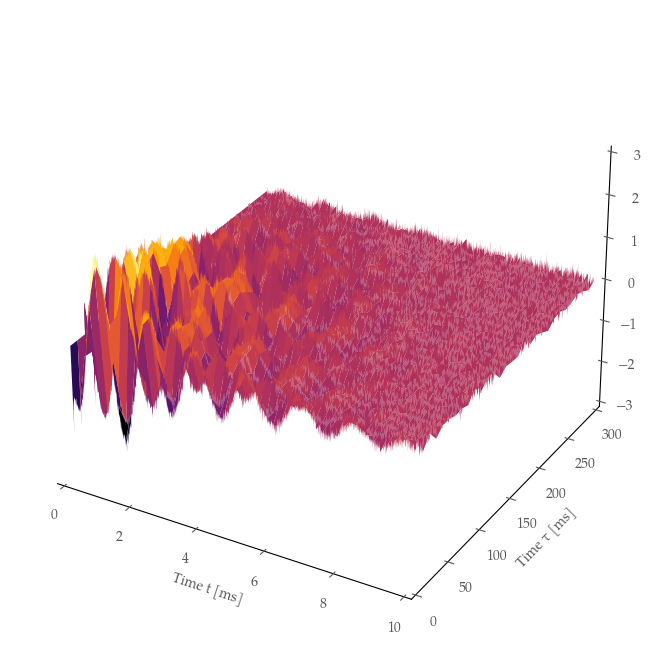

In [3]:
fids_data = np.array([fid.data for fid in fids])
fids_time = np.array([fid.us_scale for fid in fids]) / 1000
fids_tau = np.array(delays_tau_us) / 1000
fids_tau =np.repeat(fids_tau[:,np.newaxis], fids_data.shape[1], axis=-1)

# Plot raw data 3D
plt.rcParams["axes.autolimit_mode"] = "round_numbers"
plt.rcParams["axes.xmargin"] = 0
plt.rcParams["axes.ymargin"] = 0
plt.rcParams["axes.zmargin"] = 0
cm = 1/2.54
fig = plt.figure(figsize=(16*cm,16*cm))#, layout="tight")#figsize=(16*cm, 16*cm))#, layout="constrained")  # Textwidth: 16cm
axes = fig.add_subplot(projection="3d")
axes.plot_surface(fids_time, fids_tau, fids_data.real, antialiased=True, cmap="inferno")

# Plot per tau
# for delay_tau_us, fid in zip(delays_tau_us, fids):
#     axes.plot(fid.us_scale, fid.data, zs=delay_tau_us, zdir="y")

axes.set_xlabel("Time t [ms]")
axes.set_ylabel("Time τ [ms]")
axes.set_zlabel("Amplitude [a.u.]")

axes.grid(False)
axes.xaxis.set_pane_color((1.0,1.0,1.0,0.0))
axes.yaxis.set_pane_color((1.0,1.0,1.0,0.0))
axes.zaxis.set_pane_color((1.0,1.0,1.0,0.0))
plt.setp(
    [
        axes.title,
        axes.xaxis.label,
        axes.yaxis.label,
        axes.zaxis.label,
        *axes.get_xticklabels(),
        *axes.get_yticklabels(),
        *axes.get_zticklabels(),
        *(axes.get_legend().get_texts() if axes.get_legend() else ()),
    ],
    family=["TeX Gyre Pagella"]
)

color = "#575757"  # normal grey: "#6F6F6F", dark grey: "#575757"
axes.tick_params(colors=color)
axes.spines[["left", "bottom", "top", "right"]].set_color(color)
axes.xaxis.label.set_color(color)
axes.yaxis.label.set_color(color)
axes.zaxis.label.set_color(color)

fig.subplots_adjust(-0.11,0,1,1)
fig.savefig("t2_decay_3d.pdf",bbox_inches=fig.bbox_inches.from_bounds(0,0,16*cm,13*cm), pad_inches=0)

In [4]:
# Process
signal_strengths = []
for _i, fid in enumerate(fids):
    x, y = fid.simple_fft(phase_shift_kwargs=False)
    y2 = np.abs(y) ** 2
    integral = np.trapz(x=x, y=y2)
    signal_strengths.append(integral)

NameError: name 'delay_tau_us' is not defined

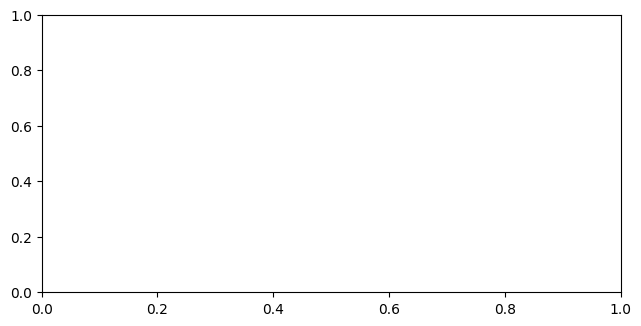

In [5]:
# Plot raw data
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    delay_tau_us,
    signal_strengths,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Signal strength [a.u.]")
axes.set_xlabel("Delay τ [μs]")

plot.adjust_for_thesis(axes)

fig.savefig("t2_decay.pdf")

In [ ]:
# Try to plot simple least squares fit
fit = process.fit_exp_decay(delay_tau_us, signal_strengths)
delay_tau_us_fine = np.linspace(
    delay_tau_us[0], delay_tau_us[-1], len(delay_tau_us) * 10
)
axes.plot(
    delay_tau_us_fine,
    fit["function"](delay_tau_us_fine),
    linestyle="-",
    linewidth=2,
)

# Save plot
fig.savefig("t2_decay_fit.pdf")
fig

NameError: name 'delay_tau_us' is not defined